# Mask output SkySat DEMs using the NMAD 

In [1]:
import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os, glob
from scipy.stats import iqr

## Define paths to data files

In [2]:
# Input file names
site_name = 'MCS'
dem_date = '20240420'
data_path = f'/Users/rdcrlrka/Research/PhD/SkySat-Stereo/study-sites/{site_name}/{dem_date}'
ortho_fn = os.path.join(data_path, f'{site_name}_{dem_date}_orthomosaic.tif')
dem_fn = os.path.join(data_path, f'{site_name}_{dem_date}_DEM.tif')
nmad_fn = os.path.join(data_path, f'{site_name}_{dem_date}_nmad_mos.tif')

# Masked DEM (output) file name
dem_masked_fn = dem_fn.replace('.tif', '_masked.tif')

for fn in [dem_fn, nmad_fn, ortho_fn]:
    if not os.path.exists(fn):
        print('File does not exist, check name:', fn)

## Load DEM, NMAD, and orthomosaic

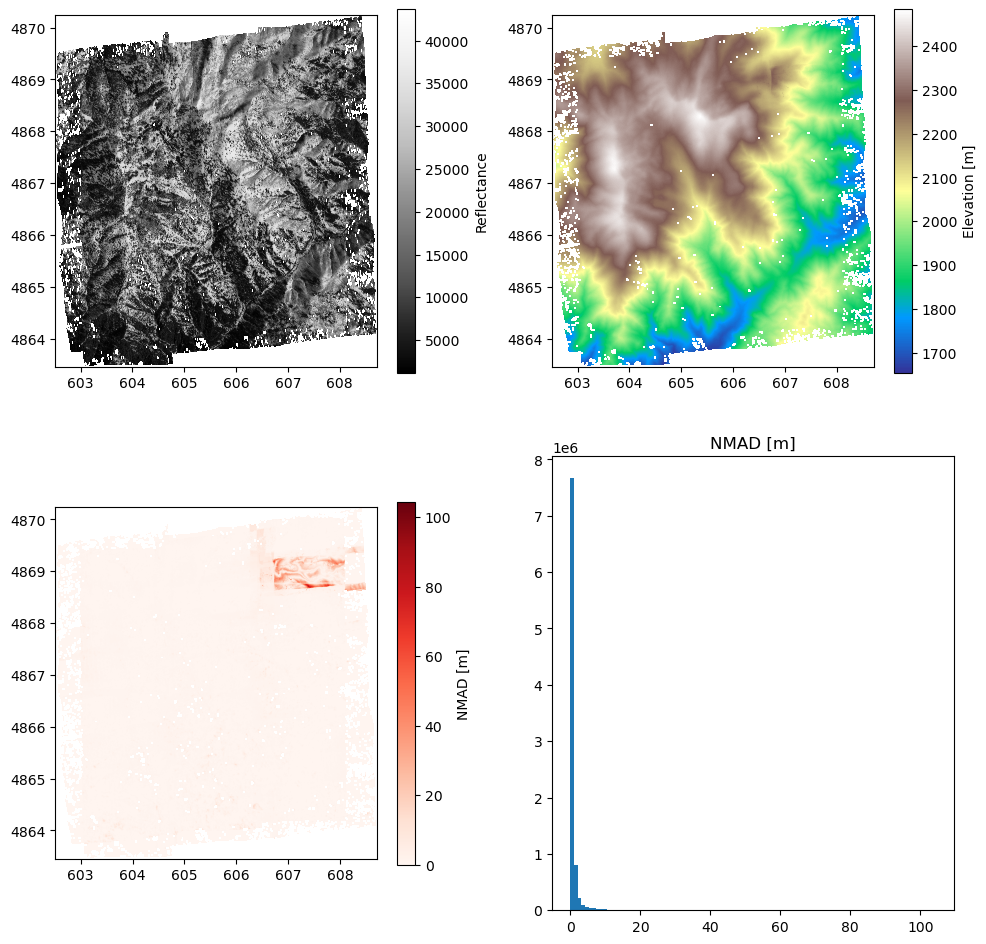

In [3]:
# Load files
ortho = rxr.open_rasterio(ortho_fn)
ortho = xr.where(ortho==ortho._FillValue, np.nan, ortho)
dem = rxr.open_rasterio(dem_fn)
dem_crs = dem.rio.crs
dem = xr.where(dem==dem._FillValue, np.nan, dem)
nmad = rxr.open_rasterio(nmad_fn)
nmad = xr.where(nmad==nmad._FillValue, np.nan, nmad)

# Plot
cbar_shrink = 0.8
fig, ax = plt.subplots(2, 2, figsize=(10,10))
ax = ax.flatten()
# orthoimage
ortho_im = ax[0].imshow(ortho.data[0], cmap='Greys_r', 
                        extent=(np.min(ortho.x.data)/1e3, np.max(ortho.x.data)/1e3, 
                                np.min(ortho.y.data)/1e3, np.max(ortho.y.data)/1e3))
fig.colorbar(ortho_im, ax=ax[0], shrink=cbar_shrink, label='Reflectance')
# DEM
ls = matplotlib.colors.LightSource(azdeg=315, altdeg=45)
dem_im = ax[1].imshow(dem.data[0], cmap='terrain',
                      extent=(np.min(dem.x.data)/1e3, np.max(dem.x.data)/1e3, 
                              np.min(dem.y.data)/1e3, np.max(dem.y.data)/1e3))
fig.colorbar(dem_im, ax=ax[1], shrink=cbar_shrink, label='Elevation [m]')
# NMAD
nmad_im = ax[2].imshow(nmad.data[0], cmap='Reds', 
                       extent=(np.min(nmad.x.data)/1e3, np.max(nmad.x.data)/1e3, 
                               np.min(nmad.y.data)/1e3, np.max(nmad.y.data)/1e3))
fig.colorbar(nmad_im, ax=ax[2], shrink=cbar_shrink, label='NMAD [m]')
ax[3].hist(np.ravel(nmad.data), bins=100)
ax[3].set_title('NMAD [m]')

fig.tight_layout()
plt.show()

## Test some methods for automatically setting an NMAD threshold

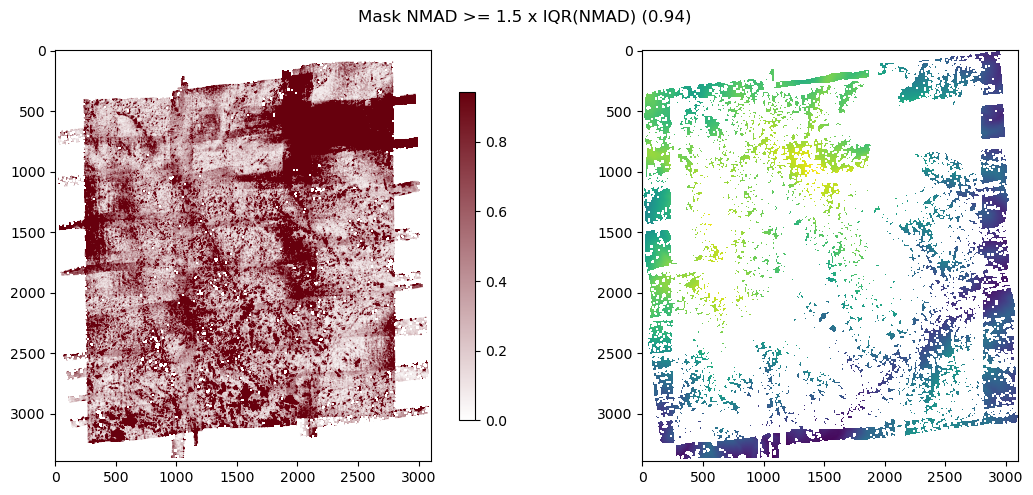

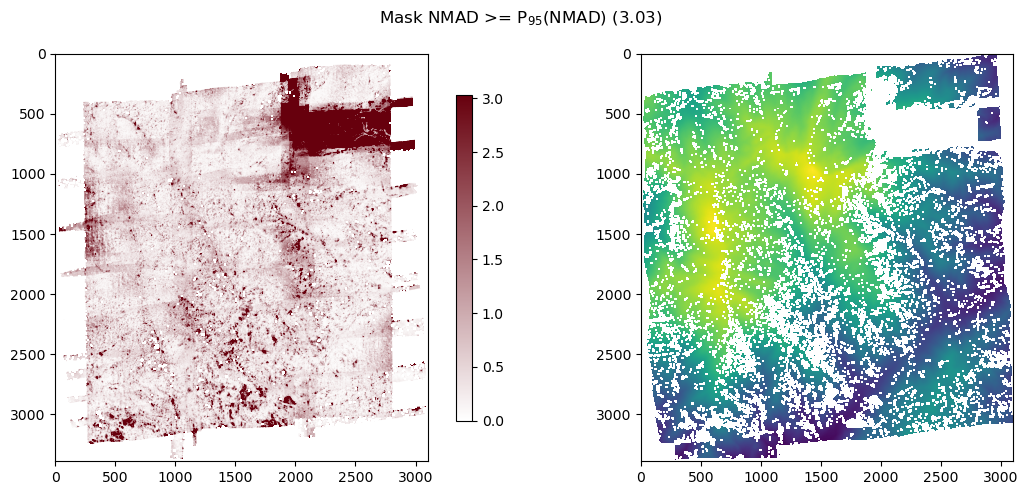

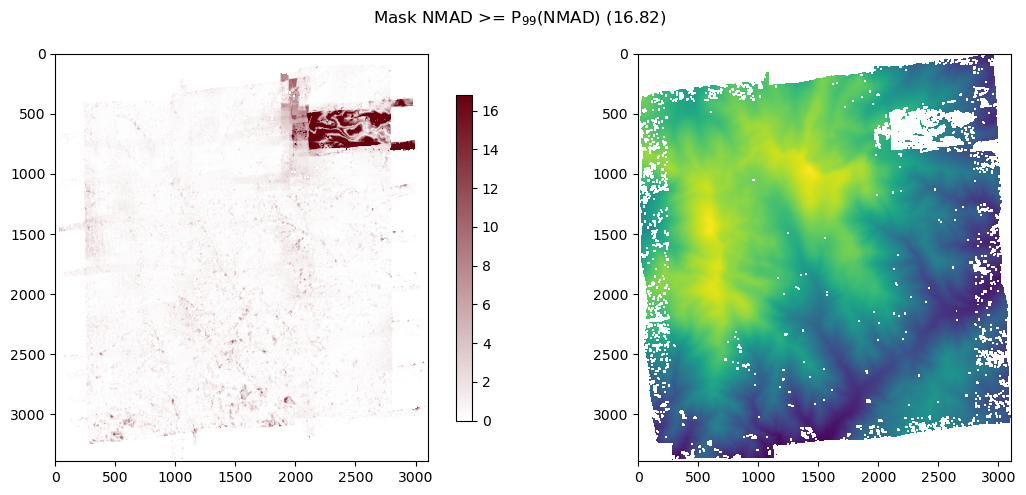

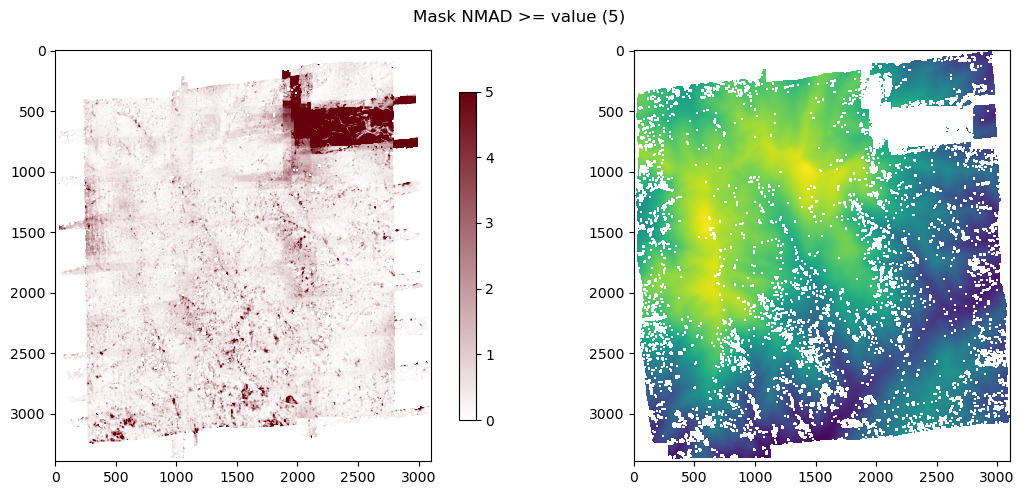

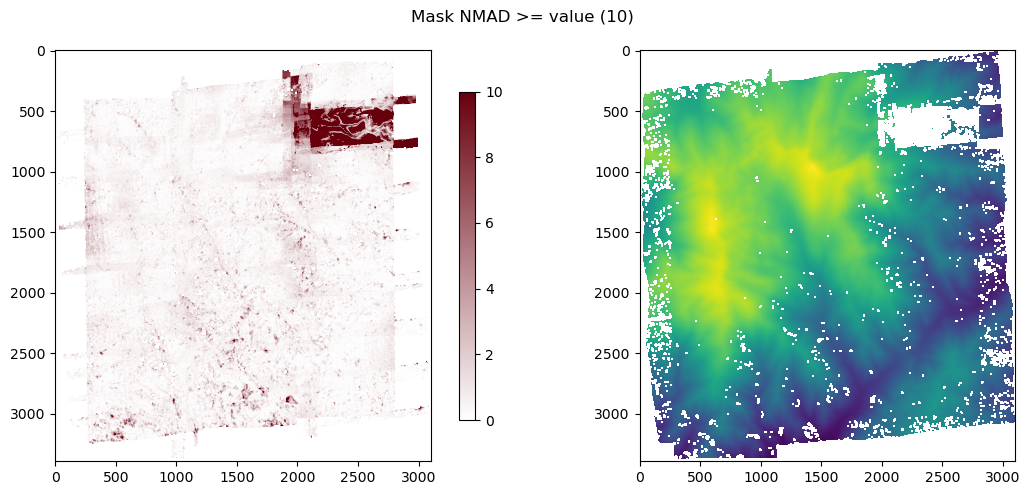

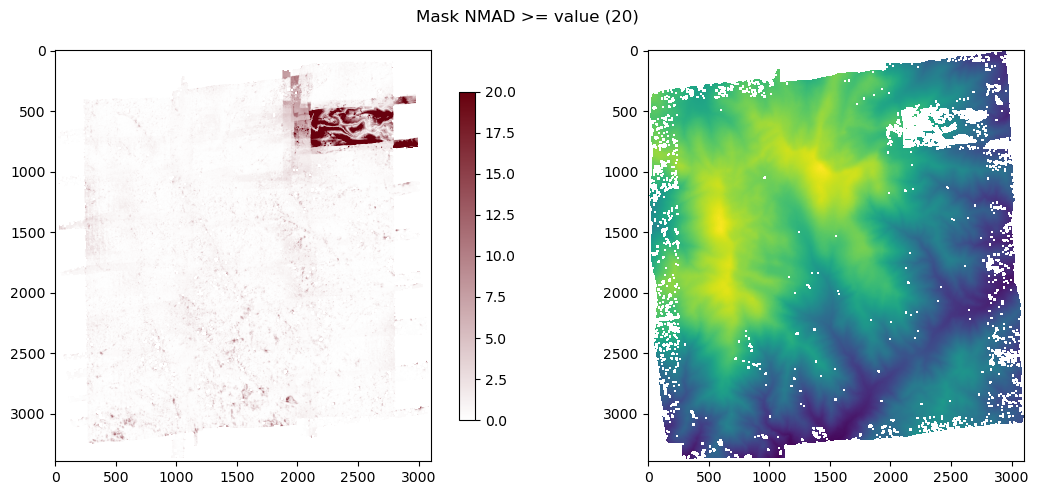

In [4]:
# Interpolate DEM to NMAD coordinates
dem_interp = dem.interp(x=nmad.x, y=nmad.y, method='nearest')

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("Custom", ['w','#67000d'])

# Define thresholds
thresholds = [[1.5 * iqr(np.ravel(nmad.data), nan_policy='omit'), '1.5 x IQR(NMAD)'],
              [np.nanpercentile(np.ravel(nmad.data), 95), 'P$_{95}$(NMAD)'],
              [np.nanpercentile(np.ravel(nmad.data), 99), 'P$_{99}$(NMAD)'],
              [5, 'value'],
              [10, 'value'],
              [20, 'value']
             ]
                   
# Iterate over thresholds
for thresh, thresh_name in thresholds:
    mask = xr.where(nmad >= thresh, 1, 0)
    dem_interp_masked = xr.where(mask == 1, np.nan, dem_interp)
    # plot
    fig, ax = plt.subplots(1, 2, figsize=(12,5))
    nmad_im = ax[0].imshow(nmad.data[0], cmap=cmap, clim=(0,thresh))
    fig.colorbar(nmad_im, ax=ax[0], shrink=cbar_shrink)
    ax[1].imshow(dem_interp_masked.data[0])
    fig.suptitle(f"Mask NMAD >= {thresh_name} ({np.round(thresh, 2)})")
    fig.tight_layout()
    plt.show()


## Apply NMAD threshold, save to file

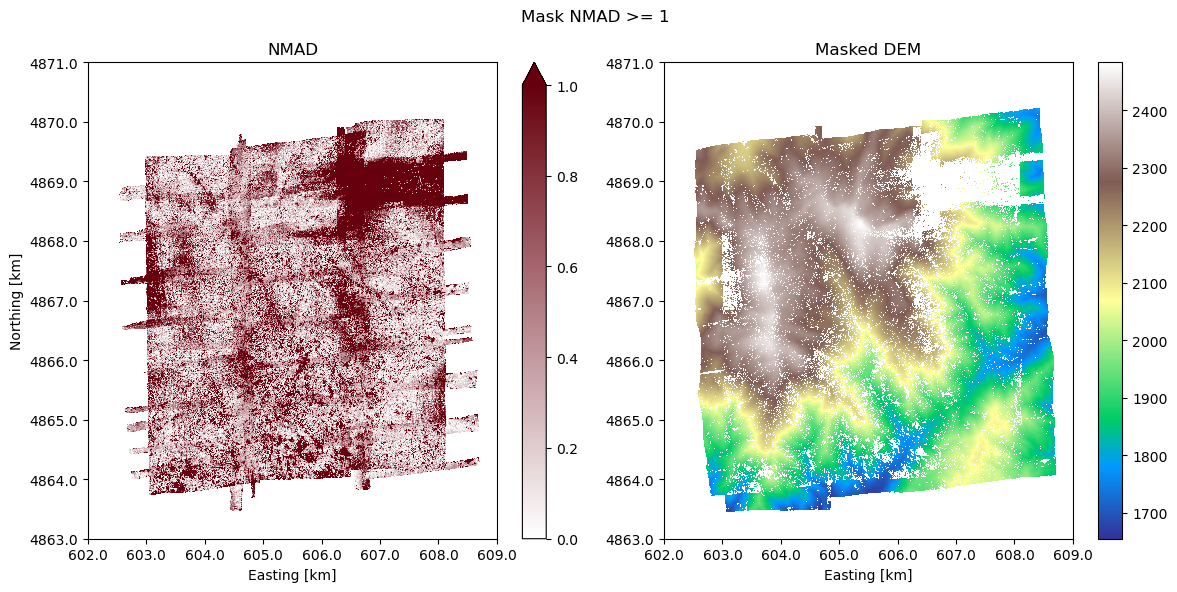

Masked DEM saved to file: /Users/rdcrlrka/Research/PhD/SkySat-Stereo/study-sites/MCS/20240420/MCS_20240420_DEM_masked.tif


In [30]:
# Apply threshold
thresh = 1
mask = xr.where(nmad >= thresh, 1, 0)
dem_interp_masked = xr.where(mask == 1, np.nan, dem_interp)

# Write CRS
dem_interp_masked = dem_interp_masked.rio.write_crs(dem_crs)

# Plot
fig, ax = plt.subplots(1, 2, figsize=(12,6))
thresh_im = nmad.plot(cmap=cmap, vmin=0, vmax=thresh, ax=ax[0])
dem_im = dem_interp_masked.plot(cmap='terrain', ax=ax[1])
for axis in ax:
    axis.set_xticks(axis.get_xticks())
    axis.set_xticklabels(np.divide(axis.get_xticks(), 1e3).astype(str))
    axis.set_yticks(axis.get_yticks())
    axis.set_yticklabels(np.divide(axis.get_yticks(), 1e3).astype(str))
ax[0].set_xlabel('Easting [km]')
ax[0].set_ylabel('Northing [km]')
ax[1].set_xlabel('Easting [km]')
ax[1].set_ylabel('')
ax[0].set_title('NMAD')
ax[1].set_title('Masked DEM')
fig.suptitle(f"Mask NMAD >= {np.round(thresh, 2)}")
fig.tight_layout()
plt.show()

# Save to file
dem_masked_fn = dem_fn.replace('.tif', '_masked.tif')
dem_interp_masked.rio.to_raster(dem_masked_fn)
print('Masked DEM saved to file:', dem_masked_fn)